In [1]:
# Cell 1 Import Statements
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
# Cell 2
# Read in car and non-car images
cars = []
notcars = []

images = glob.glob('../vehicles/GTI_Far/*.png')
for image in images:
        cars.append(image)
        
images = glob.glob('../vehicles/GTI_Left/*.png')
for image in images:
        cars.append(image)
        
images = glob.glob('../vehicles/GTI_MiddleClose/*.png')
for image in images:
        cars.append(image)
        
images = glob.glob('../vehicles/GTI_Right/*.png')
for image in images:
        cars.append(image)

images = glob.glob('../vehicles/KITTI_extracted/*.png')
for image in images:
        cars.append(image)
        
print("Total Car Images: ",len(cars))

images = glob.glob('../non-vehicles/Extras/*.png')
for image in images:
        notcars.append(image)

images = glob.glob('../non-vehicles/GTI/*.png')
for image in images:
        notcars.append(image)
        
print("Total Non-car Images: ",len(notcars))

Total Car Images:  8792
Total Non-car Images:  8968


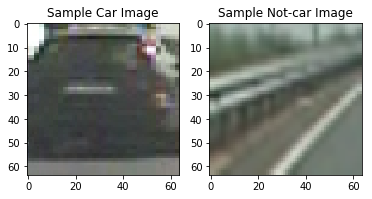

In [3]:
# Cell 3
# Randomly selecting an index to show sample image
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Reading sample car/non-car image
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Sample Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Sample Not-car Image')
fig.savefig('output_images/sample-data.jpg')

In [4]:
# Cell 4 - Defining Contant to be used throughout the code
colorspace = 'YCrCb'
pix_per_cell = 8
cell_per_block = 2
orient = 9
spatial_size = (32, 32)
hist_bins = 32
hog_channel = 'ALL'
y_start_stop = [352, 656]
x_start_stop = [200, 1260]
scale = 1.5

In [5]:
# Cell 5 - Defining functions for Bin Spinning, Color Histogram, HOG feauture 
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [6]:
# Cell 6
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in imgs:
        # Read in each one by one
        image = mpimg.imread(img)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        spatial_features = bin_spatial(feature_image, size=spatial_size)
        hist_features = color_hist(feature_image, nbins=hist_bins)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        
    # Return list of feature vectors
    return features

1681


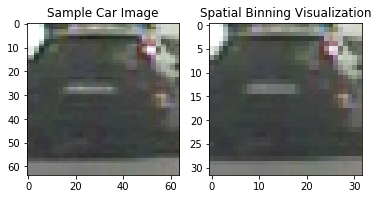

In [7]:
# Cell 7 - Extract features for a sample car image
# Spatial Binning Visualization
print(car_ind)
image = mpimg.imread(cars[car_ind])
spatial_binning_img = cv2.resize(image, (32,32))
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Sample Car Image')
plt.subplot(122)
plt.imshow(spatial_binning_img, cmap='gray')
plt.title('Spatial Binning Visualization')
fig.savefig('output_images/spatial_binning.jpg')

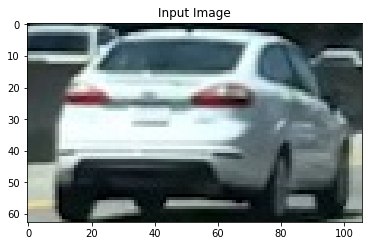

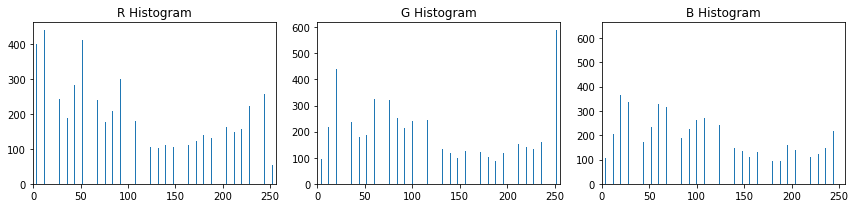

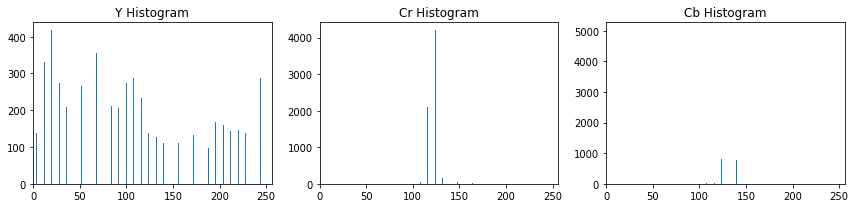

In [8]:
# Cell - 8Color Histogram Visualization
image = mpimg.imread("test_images/cutout1.jpg")
plt.title('Input Image')
plt.imshow(image, cmap='gray')

channel0_hist = np.histogram(image[:,:,0], bins=32, range=(0, 256))
channel1_hist = np.histogram(image[:,:,1], bins=32, range=(0, 256))
channel2_hist = np.histogram(image[:,:,2], bins=32, range=(0, 256))
# Calculating bin centers
bin_edges = channel0_hist[1]
bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

# Plot a figure with all three bar charts
if channel0_hist is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bin_centers, channel0_hist[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bin_centers, channel1_hist[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bin_centers, channel2_hist[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
    fig.savefig('output_images/RGB_channel_hist.jpg')
else:
    print('Your function is returning None for at least one variable')

feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
channel0_hist = np.histogram(feature_image[:,:,0], bins=32, range=(0, 256))
channel1_hist = np.histogram(feature_image[:,:,1], bins=32, range=(0, 256))
channel2_hist = np.histogram(feature_image[:,:,2], bins=32, range=(0, 256))
# Calculating bin centers
bin_edges = channel0_hist[1]
bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

# Plot a figure with all three bar charts
if channel0_hist is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bin_centers, channel0_hist[0])
    plt.xlim(0, 256)
    plt.title('Y Histogram')
    plt.subplot(132)
    plt.bar(bin_centers, channel1_hist[0])
    plt.xlim(0, 256)
    plt.title('Cr Histogram')
    plt.subplot(133)
    plt.bar(bin_centers, channel2_hist[0])
    plt.xlim(0, 256)
    plt.title('Cb Histogram')
    fig.tight_layout()
    fig.savefig('output_images/YCrCb_channel_hist.jpg')
else:
    print('Your function is returning None for at least one variable')

C:\Users\nehsoni\AppData\Local\Continuum\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


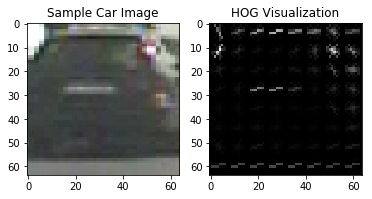

In [9]:
# Cell 9 - HOG Visualization
# Read in the image
image = mpimg.imread(cars[car_ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Sample Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
fig.savefig('output_images/HOG_visualization.jpg')

In [10]:
# Cell 10
# Training a classifier
t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Predicting random 10 test features
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

C:\Users\nehsoni\AppData\Local\Continuum\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


94.43 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
23.88 Seconds to train SVC...
Test Accuracy of SVC =  0.9916
My SVC predicts:  [ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  0.  0.  1.  0.  0.]
23.9396 Seconds to predict 10 labels with SVC


In [28]:
# Cell 11
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, x_start_stop, y_start_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    xstart = x_start_stop[0]
    xstop = x_start_stop[1]
    ystart = y_start_stop[0]
    ystop = y_start_stop[1]
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient*cell_per_block**2 
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    window_list = []
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                
            test_prediction = svc.predict(test_features)
            
            # If positive (prediction == 1) then save the window
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                startx = xbox_left
                starty = ytop_draw+ystart
                endx = xbox_left+win_draw
                endy = ytop_draw+win_draw+ystart
                window_list.append(((startx, starty), (endx, endy)))
                cv2.rectangle(draw_img, (startx, starty), (endx, endy), (0,0,255), 6) 
                
    return window_list, draw_img

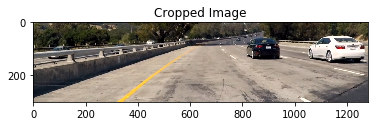

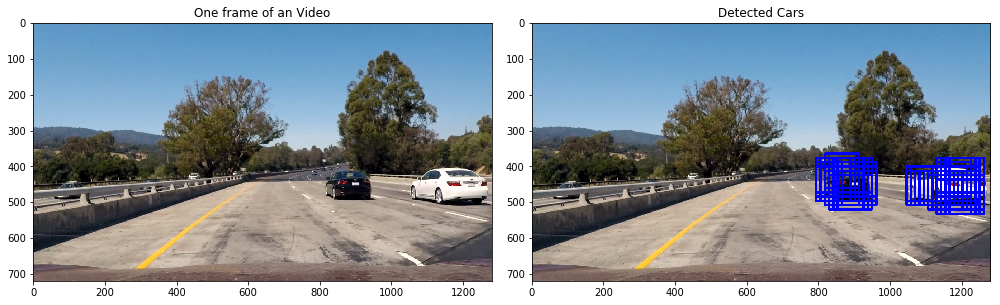

In [36]:
# Cell 12 - Testing the classifier on one whole image
test_img = mpimg.imread('test_images/test1.jpg')

window_list, out_img = find_cars(test_img, x_start_stop, y_start_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

test_img = test_img.astype(np.float32)/255
img_tosearch = test_img[y_start_stop[0]:y_start_stop[1],:,:]
plt.imshow(img_tosearch)
plt.title('Cropped Image')

fig = plt.figure(figsize=(14, 12))
plt.subplot(121)
plt.imshow(test_img, cmap='gray')
plt.title('One frame of an Video')
plt.subplot(122)
plt.imshow(out_img, cmap='gray')
plt.title('Detected Cars')
fig.tight_layout()
fig.savefig('output_images/finding_cars.jpg')

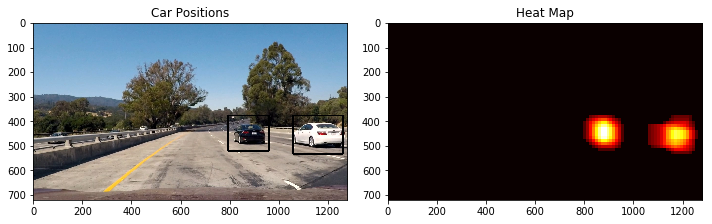

In [30]:
# Cell 13
from scipy.ndimage.measurements import label
heat = np.zeros_like(test_img[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat, window_list)
    
# Apply threshold to help remove false positives
heatmap = apply_threshold(heat, 2)

# Visualize the heatmap when displaying    
#heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test_img), labels)

fig = plt.figure(figsize=(10, 8))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
fig.savefig('output_images/multiple_detection.jpg')

In [33]:
# Cell 14
# video pipeline
def processing_pipeline(image):
    window_list, out_img = find_cars(image, x_start_stop, y_start_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, window_list)

    # Apply threshold to help remove false positives
    heatmap = apply_threshold(heat, 2)

    # Visualize the heatmap when displaying    
    #heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

In [37]:
# Cell 15
from moviepy.editor import VideoFileClip
from IPython.display import HTML

project_video_processed = 'processed_project_video_full.mp4'
video = VideoFileClip("project_video.mp4", audio=False)
processed_clip = video.fl_image(processing_pipeline)
processed_clip.write_videofile(project_video_processed, audio=False)

[MoviePy] >>>> Building video processed_project_video_full.mp4
[MoviePy] Writing video processed_project_video_full.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [29:29<00:01,  1.49s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_project_video_full.mp4 



In [ ]:
# Cell 16 - Play video in browser
project_video_processed = 'processed_project_video_full.mp4'

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_processed))